In [1]:
from helpers.other_helpers import *
from helpers.viz_helpers import *
pd.set_option('display.float_format', '{:.2f}'.format)


In [15]:
s3 = s3_connection()
df = s3.get_tables_from_s3("aayrapetyan/diffusion/final_table.parquet")
df.sample(3)

connection successful


total_voyageurs_2022           nom_gare       uic codeinsee  lon_gare  \
950               1022933             Nevers  87696005     58194      3.15   
526               5334560  Vigneux-sur-Seine  87681304     91657      2.41   
633                 20021             Cantin  87345413     59126      3.12   

     lat_gare codecommune         nomcommune  pop2022  revmoy2022  ...  \
950     46.99       58194             NEVERS 29617.00    17807.17  ...   
526     48.71       91657  VIGNEUX-SUR-SEINE 34823.00    14068.29  ...   
633     50.31       59126             CANTIN  1637.00    16154.11  ...   

     psup2022  pagri2022  pindp2022  pcadr2022  ppint2022  pempl2022  \
950      0.29       0.00       0.07       0.17       0.21       0.29   
526      0.30       0.00       0.03       0.16       0.22       0.37   
633      0.40       0.02       0.02       0.15       0.22       0.35   

     pouvr2022  pchom2022  dist_closest_station_km                  regions  
950       0.26       0.12                     2.01  Bourgogne-Franche-Comté  
526       0.21       0.10                     0.93            Île-de-France  
633       0.24       0.05                     2.91          Hauts-de-France  

[3 rows x 21 columns]

In [16]:
df.describe().drop("count").drop(columns=["lon_gare", "lat_gare"]).round(2)

total_voyageurs_2022   pop2022  revmoy2022  pbac2022  psup2022  \
mean             745465.89  18078.54    18221.52      0.46      0.29   
std             3178484.88  50290.90     6608.60      0.13      0.13   
min                   1.00     55.00     5818.04      0.00      0.00   
25%               12938.50   1570.25    14922.08      0.37      0.20   
50%               60333.50   4067.50    16931.46      0.45      0.28   
75%              289815.25  12203.00    19639.30      0.54      0.37   
max           102910589.00 875791.00   107572.81      1.00      1.00   

      pagri2022  pindp2022  pcadr2022  ppint2022  pempl2022  pouvr2022  \
mean       0.01       0.07       0.14       0.26       0.29       0.23   
std        0.04       0.06       0.11       0.11       0.11       0.12   
min        0.00       0.00       0.00       0.00       0.00       0.00   
25%        0.00       0.04       0.07       0.21       0.23       0.14   
50%        0.00       0.06       0.12       0.26       0.29       0.22   
75%        0.01       0.09       0.19       0.31       0.35       0.30   
max        0.58       0.67       0.82       0.92       1.00       1.00   

      pchom2022  dist_closest_station_km  
mean       0.07                     4.86  
std        0.05                     3.73  
min        0.00                     0.12  
25%        0.04                     2.22  
50%        0.07                     3.82  
75%        0.10                     6.27  
max        0.48                    30.39

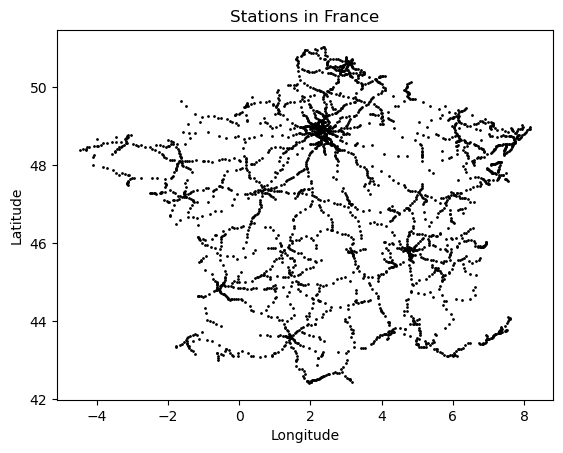

In [17]:
simple_plot_map(lat=df["lat_gare"], lon=df["lon_gare"])
idf=df[df["regions"]=="Île-de-France"]


In [18]:
df["total_voyageurs_2022_log"] =  np.log(df["total_voyageurs_2022"])
df["pop2022_log"] =  np.log(df["pop2022"])
df["pagri2022_log"] =  np.log(df["pagri2022"]+0.0001)
df["ratio_voyag_popul"] =  df["total_voyageurs_2022"] / df["pop2022"]
df["ratio_voyag_popul_log"] =  np.log(df["total_voyageurs_2022"] / df["pop2022"])
df["dist_closest_station_km_log"] =  np.log(df["dist_closest_station_km"])
df_no_outliers = delete_outliers_z_score(df, np.log(df["total_voyageurs_2022"]))



nb removed observations :  18


In [19]:


def plot_square_hist(fields_names,  figsize=(13, 7)):
    len_fields=len(fields_names)
    nb_axis=int(np.ceil(len_fields / 3))#i want 3 columns in every row
    fig, axs = plt.subplots(nb_axis, 3, figsize=figsize)
    axs = axs.flatten()  # Flatten for easier iteration
    for idx, el in enumerate(fields_names):
        series = el[0]
        try:
            title_suffix = el[1]
        except:
            title_suffix=""
        ax = axs[idx]  # Select the correct subplot
        #use another function
        plot_hist(
            ax=ax,
            series=series,
            title_suffix=title_suffix

        )
    #delete duplicated legends
    for ax in axs[len(fields_names):]:
        ax.axis("off") 
    plt.show()

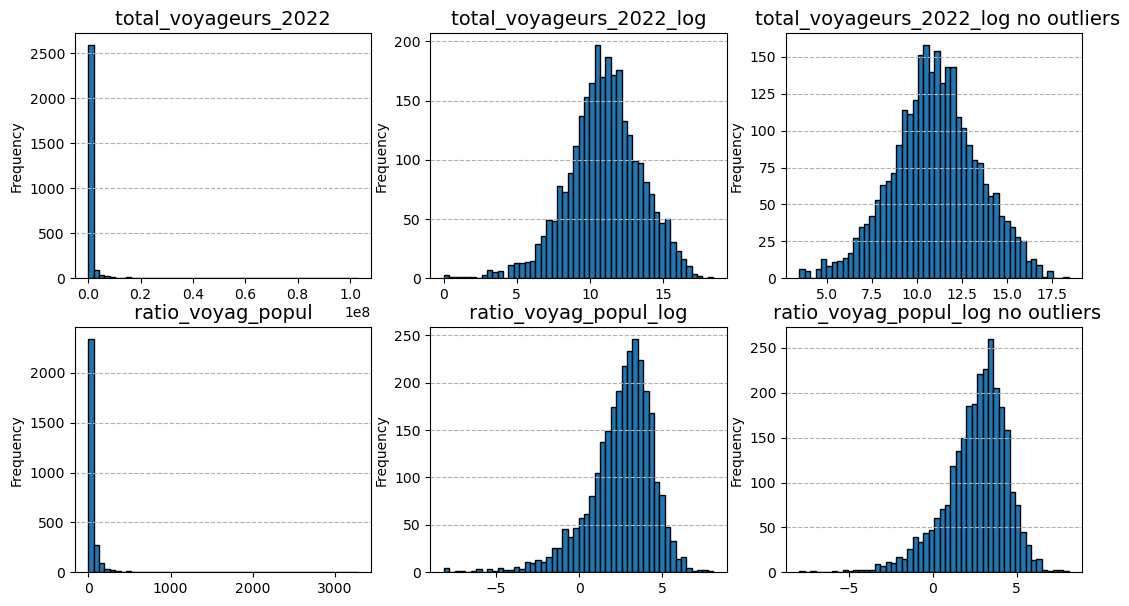

In [20]:
plot_square_hist(fields_names=[
    
    [df["total_voyageurs_2022"]],
    [df["total_voyageurs_2022_log"]],
    [df_no_outliers["total_voyageurs_2022_log"],"no outliers"],
    [df["ratio_voyag_popul"]],
    [df["ratio_voyag_popul_log"]],
    [df_no_outliers["ratio_voyag_popul_log"],"no outliers"],



        ])

In [6]:
df=df_no_outliers.copy()
aggregated_stats = calculate(
    df,
    group=["regions"],
    fields_stats_names=[
        ["total_voyageurs_2022", "sum"],
        ["pop2022", "sum"],
        ["revmoy2022", "mean"],
        ["pbac2022", "mean"],
        ["pagri2022", "mean"],
        ["pindp2022", "mean"],
        ["pcadr2022", "mean"],
        ["pempl2022", "mean"],
        ["pouvr2022", "mean"],
        ["pchom2022", "mean"],
        
    ],
)
df_for_map = df.merge(aggregated_stats, on="regions", how="inner")

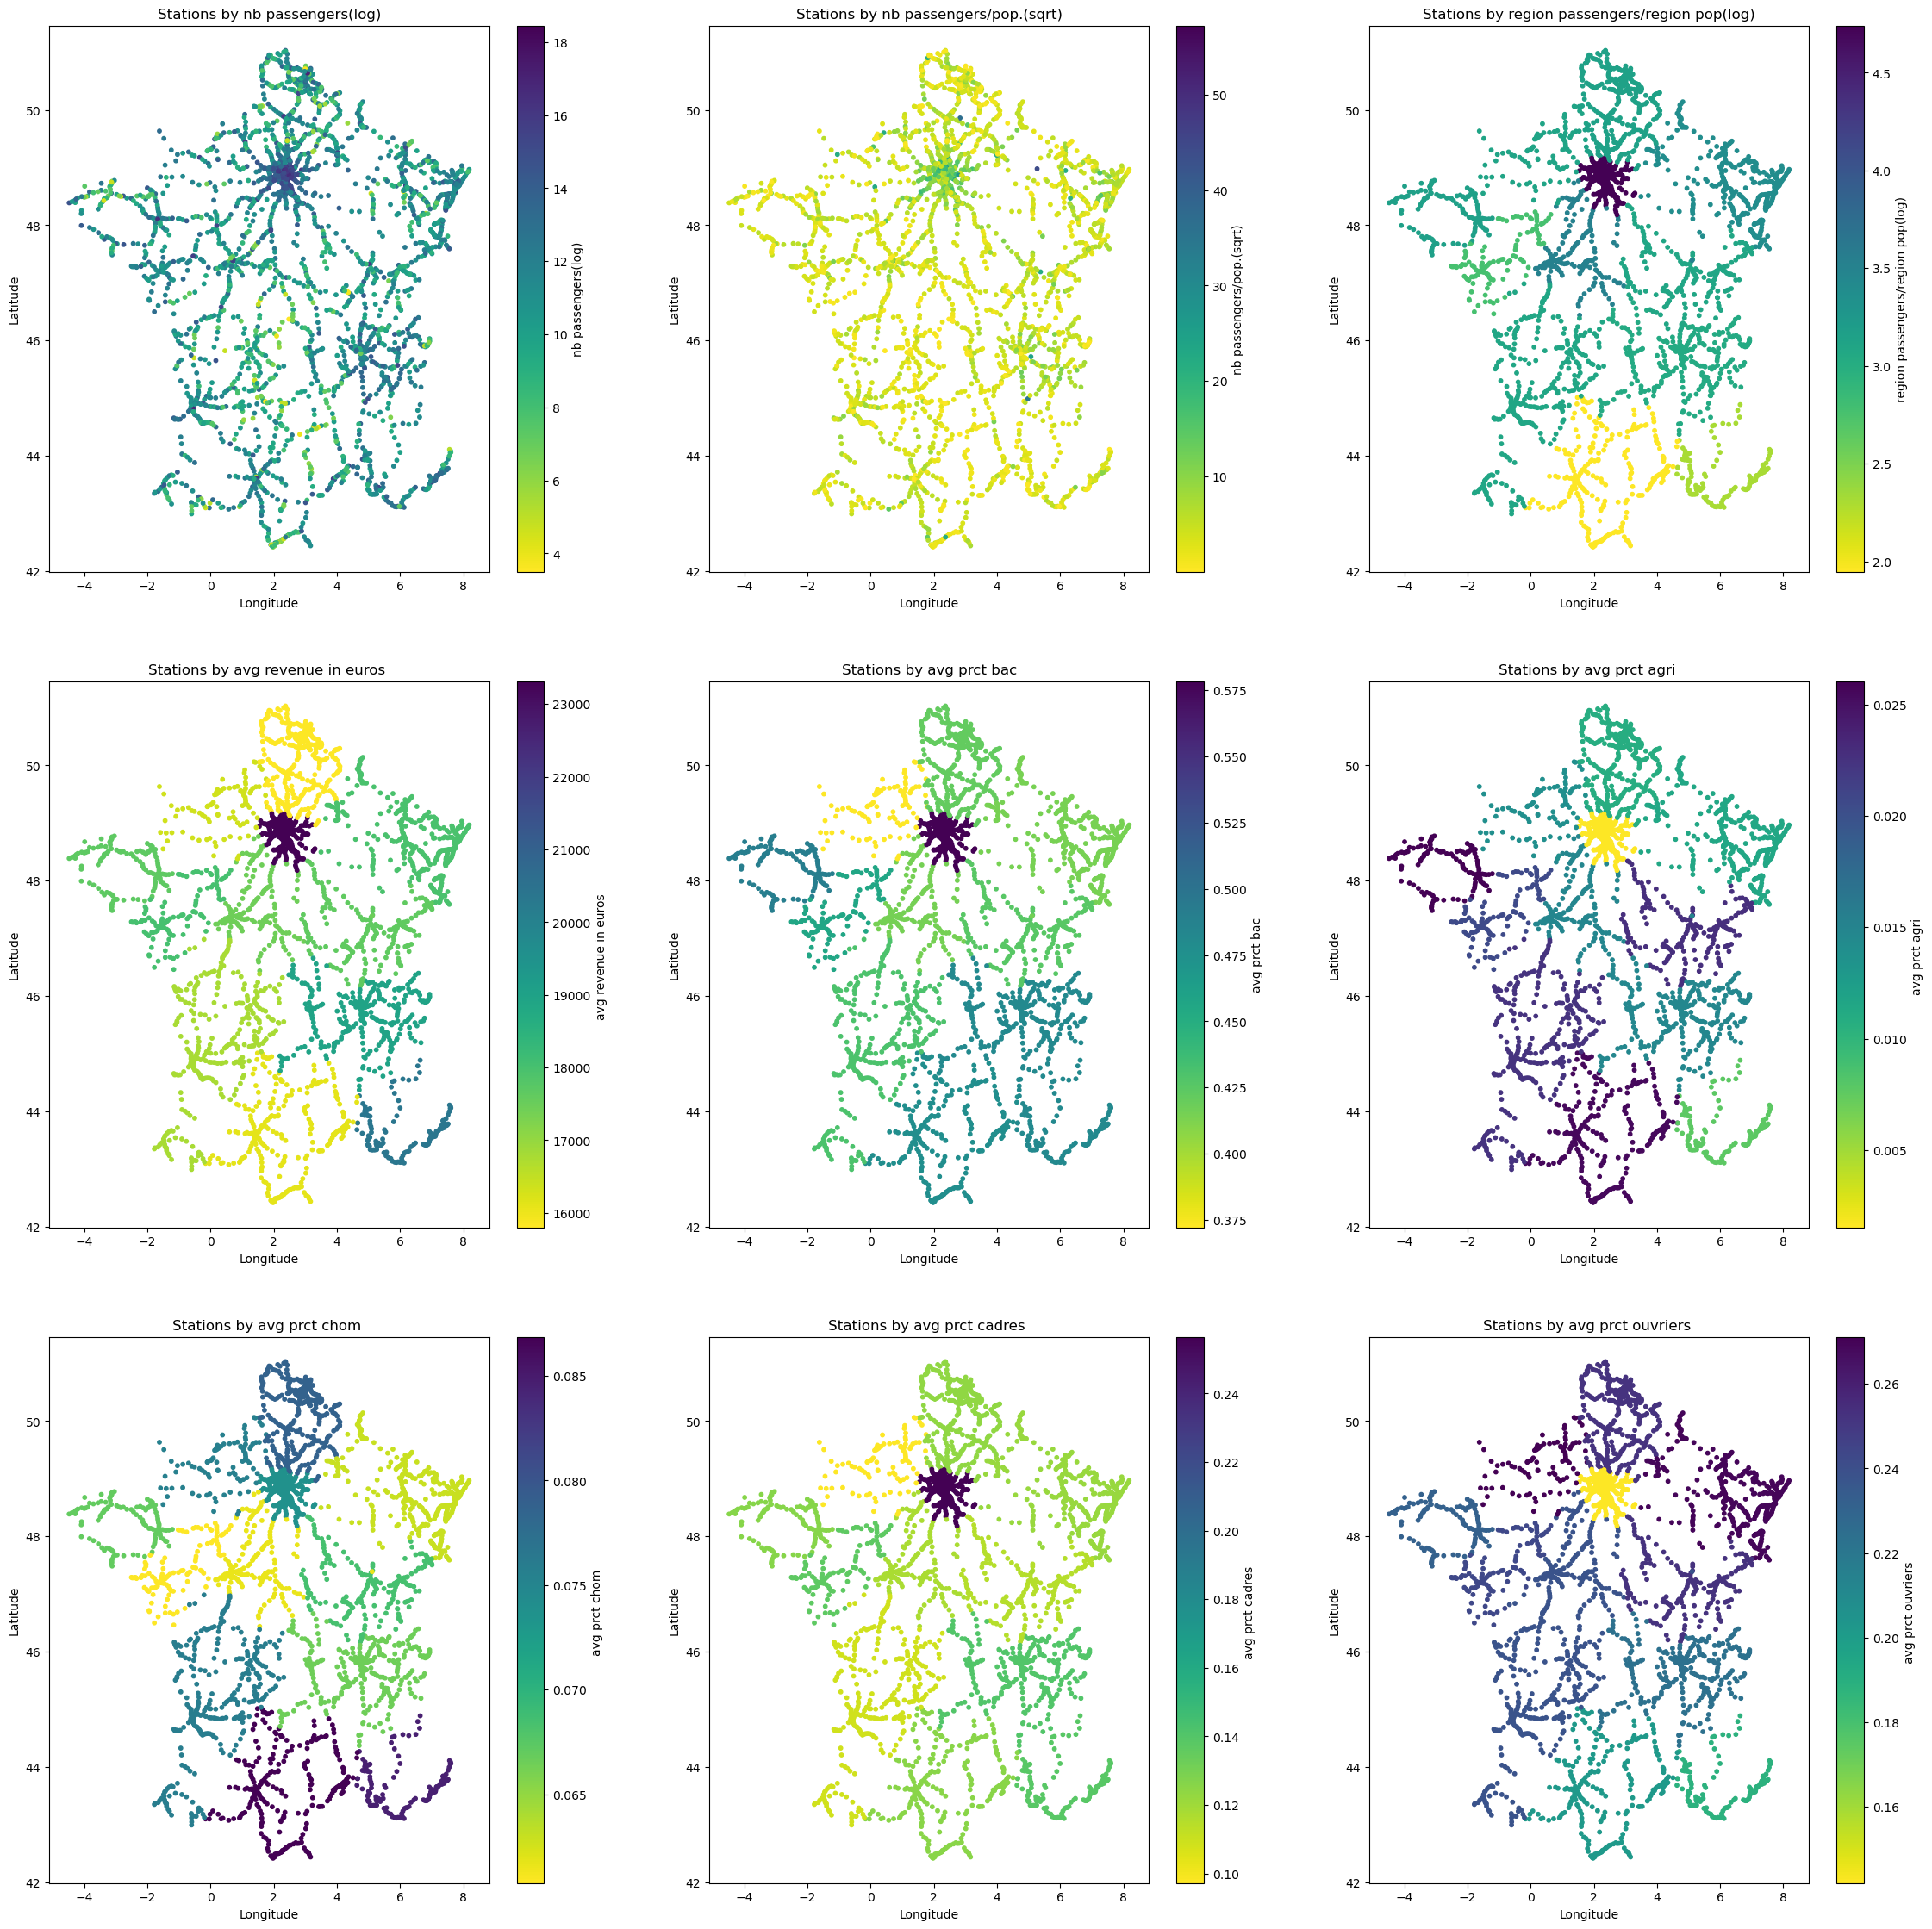

In [7]:
plot_square_map(lon=df_for_map["lon_gare"],lat=df_for_map["lat_gare"],
    fields_names=[
        [df_for_map["total_voyageurs_2022_log"], "nb passengers(log)"],
        [np.sqrt(df_for_map["ratio_voyag_popul"]),"nb passengers/pop.(sqrt)"],
        [
            np.log(
                df_for_map["total_voyageurs_2022_sum"]
                / df_for_map["pop2022_sum"]
            ),
            "region passengers/region pop(log)",
        ],
        [
            (df_for_map["revmoy2022_mean"]),
            "avg revenue in euros ",
        ],
        [
            df_for_map["pbac2022_mean"],
            "avg prct bac",
        ],
        [
            df_for_map["pagri2022_mean"],
            "avg prct agri ",
        ],
        [
            (df_for_map["pchom2022_mean"]),
            "avg prct chom ",
        ],
        [
            df_for_map["pcadr2022_mean"],
            "avg prct cadres ",
        ],
        [
            df_for_map["pouvr2022_mean"],
            "avg prct ouvriers ",
        ],
        
       
    ]
)

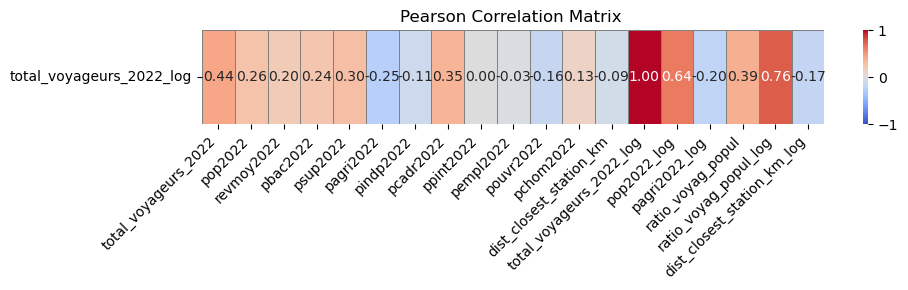

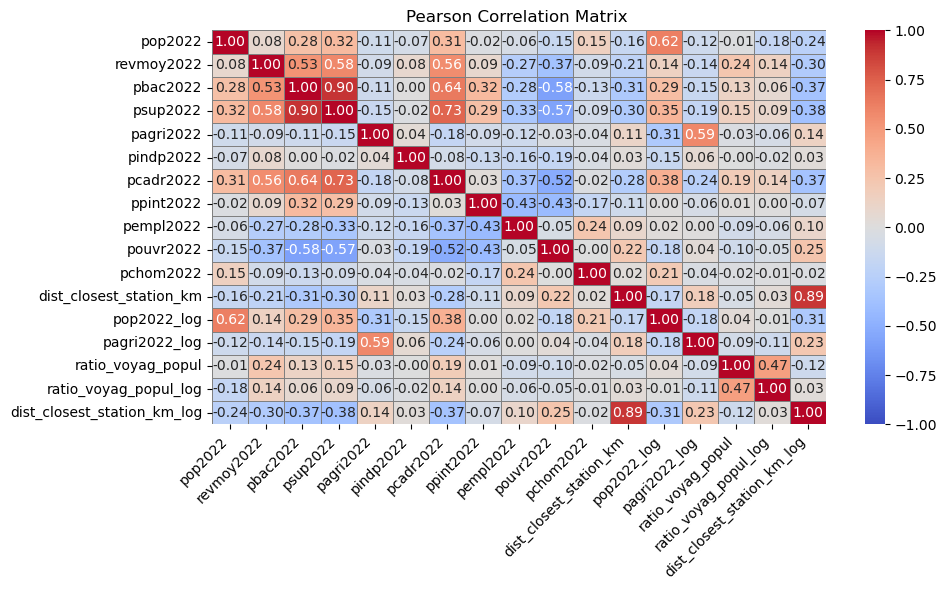

In [8]:
corr_matrix(df,filter_include=["total_voyageurs_2022_log"],filter_exclude=["lon_gare","lat_gare"],figsize=(10,3))
corr_matrix(df,filter_exclude=["total_voyageurs_2022_log","total_voyageurs_2022","lon_gare","lat_gare"])



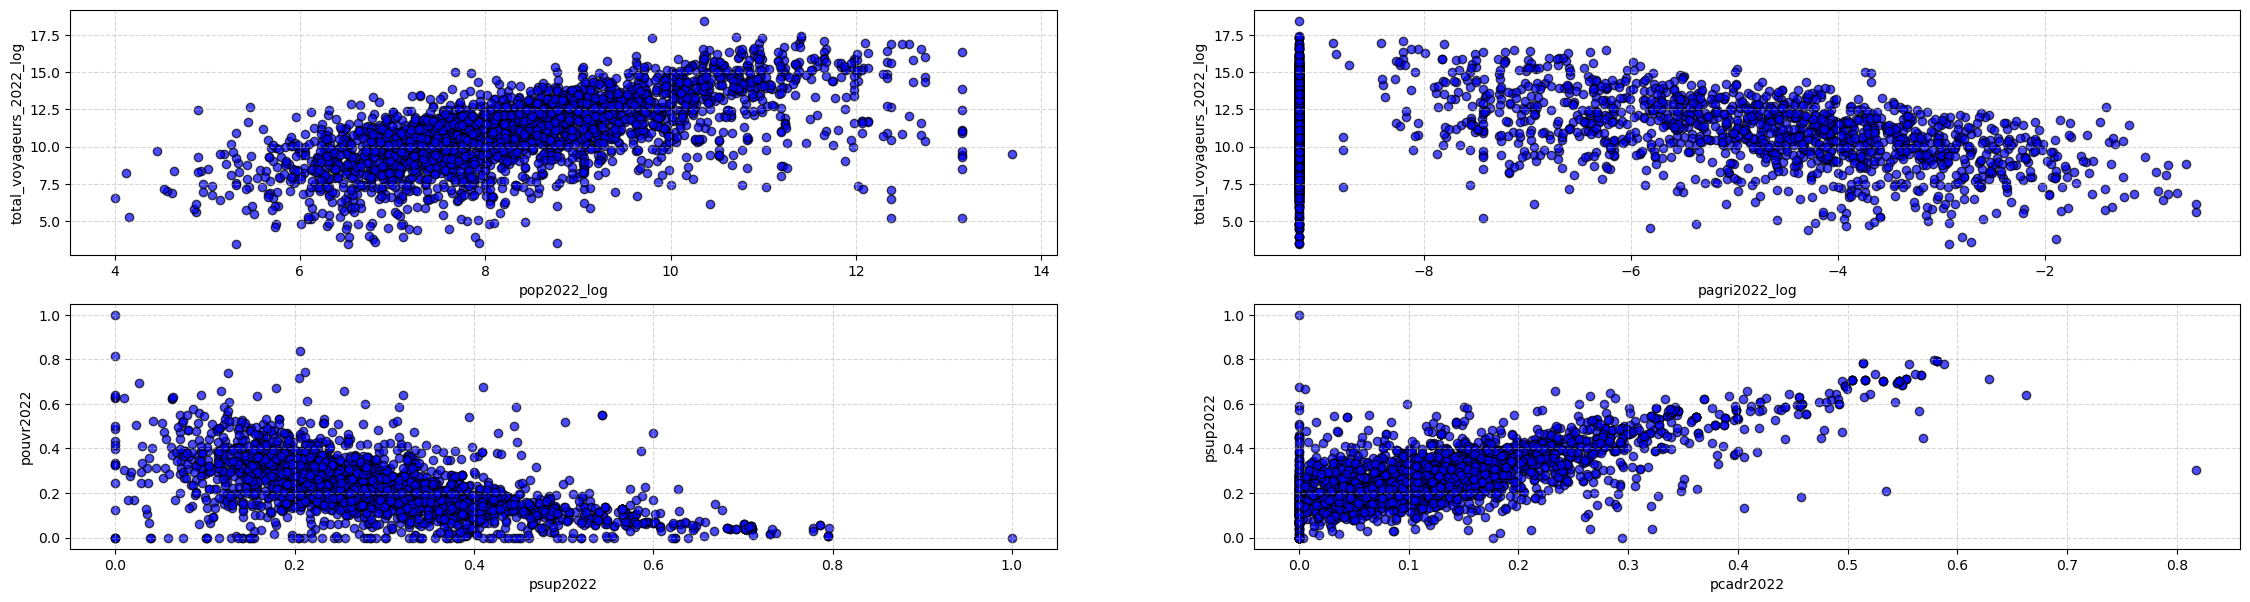

In [9]:
plot_square_scatter(fields_names=[
        [df['pop2022_log'], df['total_voyageurs_2022_log']] ,
        [df['pagri2022_log'], df['total_voyageurs_2022_log']] ,
        [df['psup2022'], df['pouvr2022']] ,
        [df['pcadr2022'], df['psup2022']]  ] ,)

now lets look at the correlation between continuos variable and categorical regional variable to see if statistically on the individual level it is nterestuing to include it to analysis

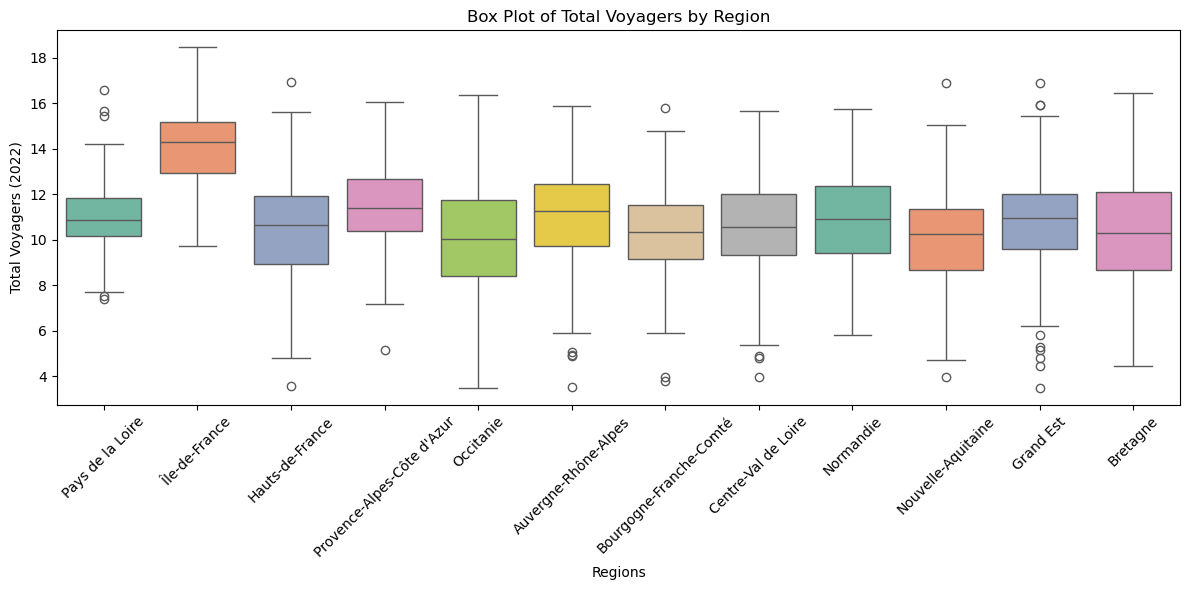

P-value: 0.0000
Rejeter l'hypothèse nulle : Au moins une moyenne de groupe est différente.
-----------------------------------------
29  combinaisons des catégories sont significativement différentes


In [10]:
analysis_between_continous_and_categorical_var(df=df,category_var='regions',interest_var='total_voyageurs_2022_log')

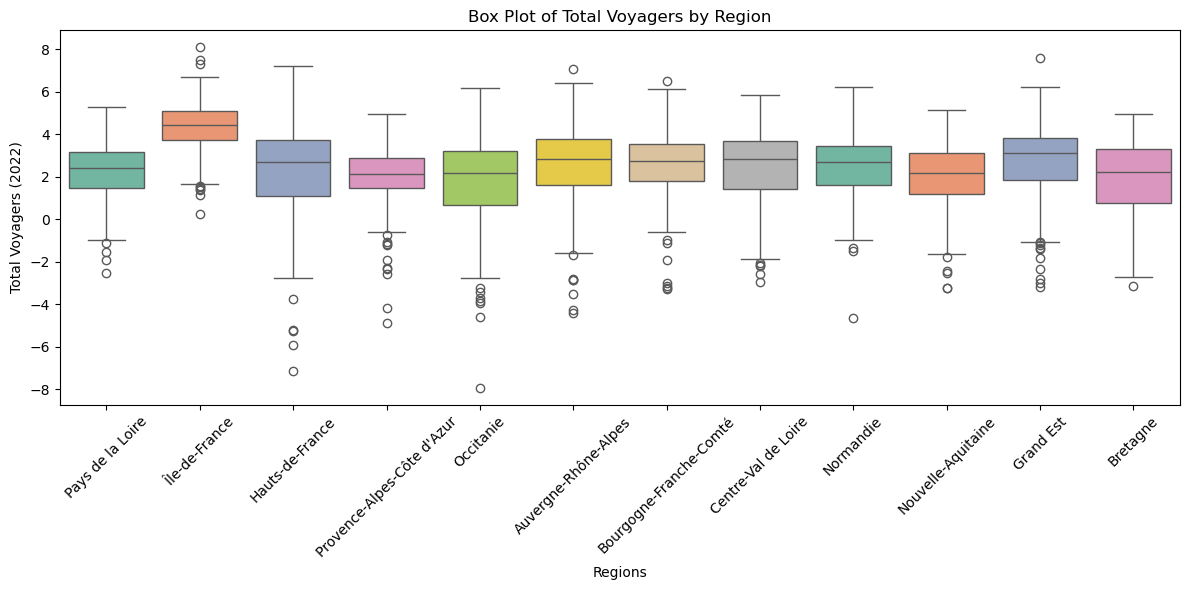

P-value: 0.0000
Rejeter l'hypothèse nulle : Au moins une moyenne de groupe est différente.
-----------------------------------------
26  combinaisons des catégories sont significativement différentes


In [11]:
analysis_between_continous_and_categorical_var(df=df,category_var='regions',interest_var='ratio_voyag_popul_log')


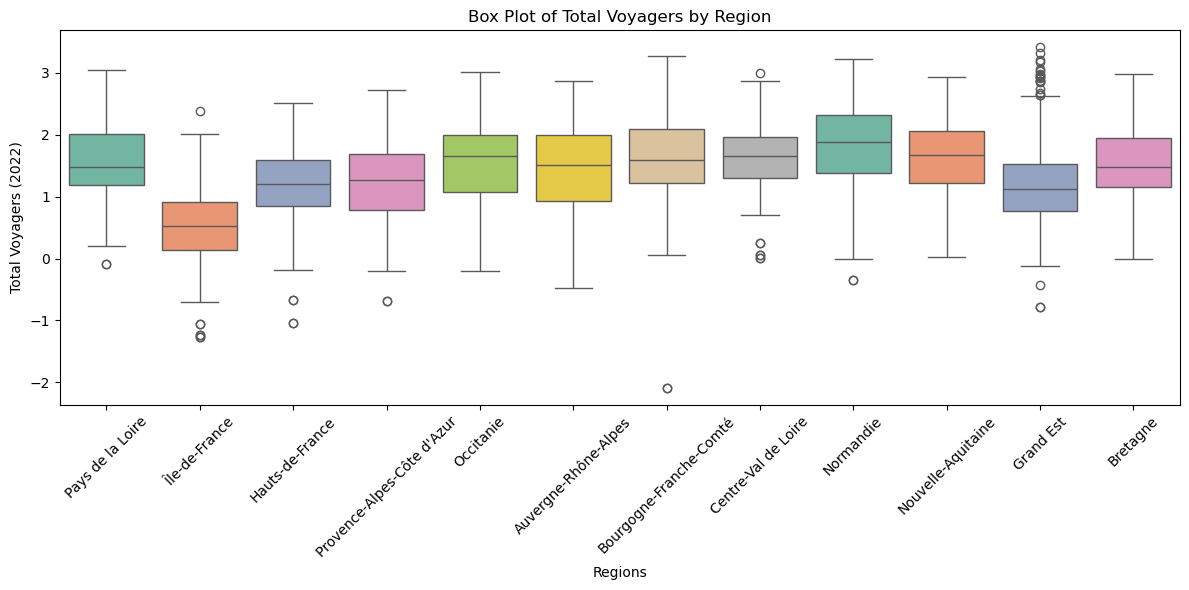

P-value: 0.0000
Rejeter l'hypothèse nulle : Au moins une moyenne de groupe est différente.
-----------------------------------------
35  combinaisons des catégories sont significativement différentes


In [12]:
analysis_between_continous_and_categorical_var(df=df,category_var='regions',interest_var='dist_closest_station_km_log')

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hist(ax, series, title_suffix=""):
    ax.hist(series, bins=50, edgecolor="black")
    ax.set_title(f"{series.name} {title_suffix}", fontsize=14)
    ax.set_ylabel("Frequency")
    ax.grid(axis="y", linestyle="--")

def plot_scatter(ax, x_series, y_series, color='blue', alpha=0.7, edgecolor='k'):
    ax.scatter(x_series, y_series, color=color, edgecolor=edgecolor, alpha=alpha)
    ax.set_xlabel(x_series.name)
    ax.set_ylabel(y_series.name)
    ax.grid(True, linestyle="--", alpha=0.5)

def plot_map_with_legend(ax, lon, lat, categorical_continuos, suffix_description):
    scatter = ax.scatter(
        lon, 
        lat, 
        s=10,  
        c=categorical_continuos,  
        cmap='viridis_r'  
    )
    cbar = plt.colorbar(scatter, ax=ax)  
    cbar.set_label(suffix_description)
    ax.set_title(f"Stations by {suffix_description}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")


def plot_square(
    fields_names,
    plot_type="hist",
    figsize=(13, 7),
    columns=3,
    lat=None,
    lon=None,
):
    """
    A unified function to create a grid of subplots and call the appropriate
    plotting function (hist/scatter/map) depending on plot_type.

    Parameters
    ----------
    fields_names : list
        - For plot_type="hist":
            Each element: [series, (optional) title_suffix]
        - For plot_type="scatter":
            Each element: [x_series, y_series]
        - For plot_type="map":
            Each element: [categorical_continuos, suffix_description]
    plot_type : str
        One of {"hist", "scatter", "map"}.
    figsize : tuple
        Figure size passed to plt.subplots.
    columns : int
        How many columns in each row of the figure.
    lat : array-like
        Latitude values (only used if plot_type="map").
    lon : array-like
        Longitude values (only used if plot_type="map").
    """
    len_fields = len(fields_names)
    nb_axis = int(np.ceil(len_fields / columns))

    fig, axs = plt.subplots(nb_axis, columns, figsize=figsize)
    axs = axs.flatten()  # Flatten for easier iteration

    for idx, el in enumerate(fields_names):
        ax = axs[idx]
        
        if plot_type == "hist":
            series = el[0]
            # optional second argument for a custom title suffix
            title_suffix = el[1] if len(el) > 1 else ""
            plot_hist(ax, series, title_suffix=title_suffix)

        elif plot_type == "scatter":
            x_series = el[0]
            y_series = el[1]
            plot_scatter(ax, x_series, y_series)

        elif plot_type == "map":
            if lat is None or lon is None:
                raise ValueError("lat and lon must be provided for plot_type='map'")
            field = el[0]
            suffix_description = el[1]
            plot_map_with_legend(ax, lon, lat, field, suffix_description)

        else:
            raise ValueError(f"Unknown plot_type: '{plot_type}'")

    # Turn off unused subplots (if any)
    for ax in axs[len_fields:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
# fields_names: each element is [series, optional_title]

plot_square(fields_names=fields_hist, plot_type="hist", columns=3, figsize=(13,7))


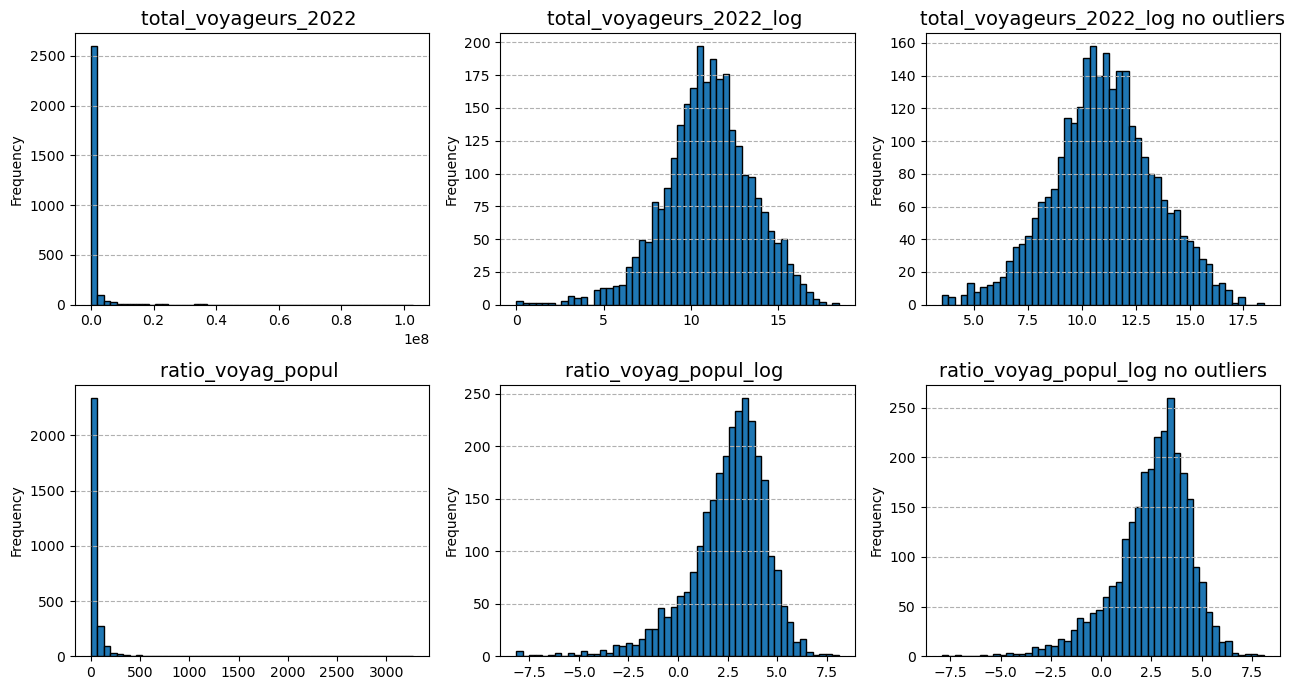

In [ ]:
plot_square(fields_names=[
    
    [df["total_voyageurs_2022"]],
    [df["total_voyageurs_2022_log"]],
    [df_no_outliers["total_voyageurs_2022_log"],"no outliers"],
    [df["ratio_voyag_popul"]],
    [df["ratio_voyag_popul_log"]],
    [df_no_outliers["ratio_voyag_popul_log"],"no outliers"],



        ],
        plot_type="hist",columns=3,)

        

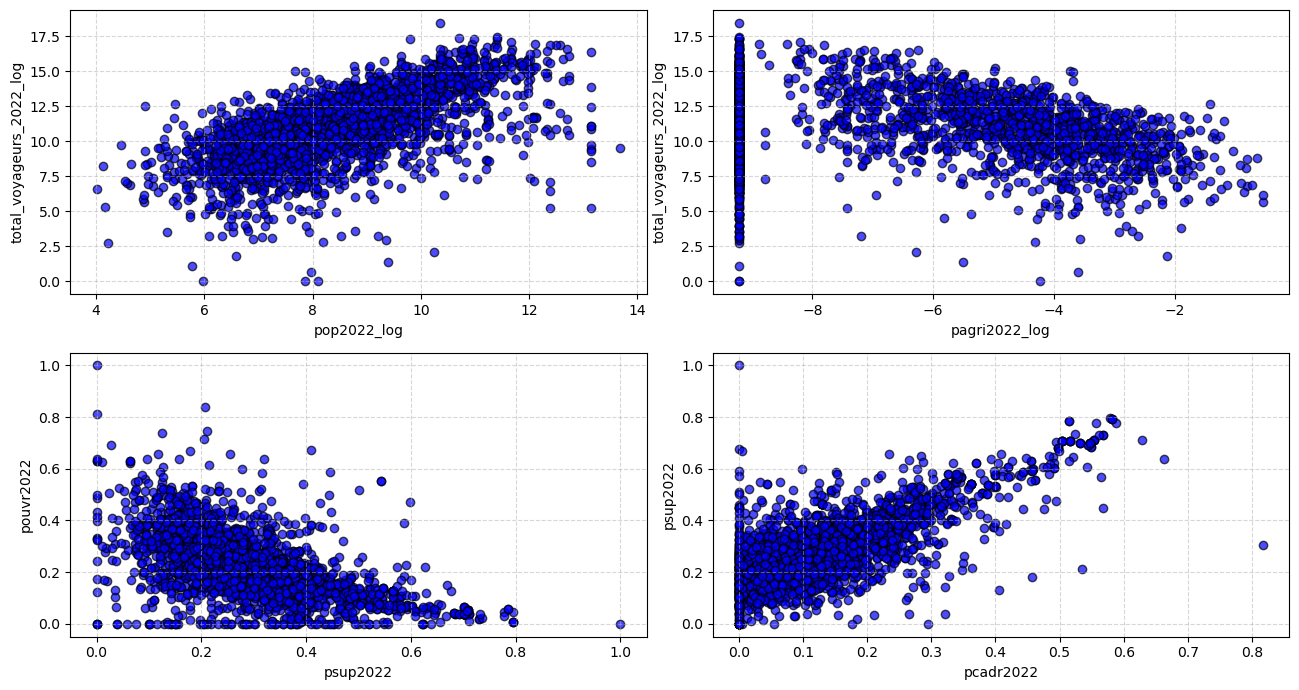

In [26]:
# fields_names: each element is [x_series, y_series]
# fields_scatter = [
#     [x_series_1, y_series_1],
#     [x_series_2, y_series_2],
#     ...
# ]
# plot_square(fields_names=fields_scatter, plot_type="scatter", columns=2, figsize=(10,5))
plot_square(fields_names=[
        [df['pop2022_log'], df['total_voyageurs_2022_log']] ,
        [df['pagri2022_log'], df['total_voyageurs_2022_log']] ,
        [df['psup2022'], df['pouvr2022']] ,
        [df['pcadr2022'], df['psup2022']]  ] , plot_type="scatter", columns=2)


In [ ]:
# fields_names: each element is [categorical_continuos, suffix_description]
fields_map = [
    [data_1, "Field 1"],
    [data_2, "Field 2"],
    ...
]
plot_square(fields_names=fields_map, plot_type="map",
            lat=lat, lon=lon, columns=3, figsize=(28, 28))


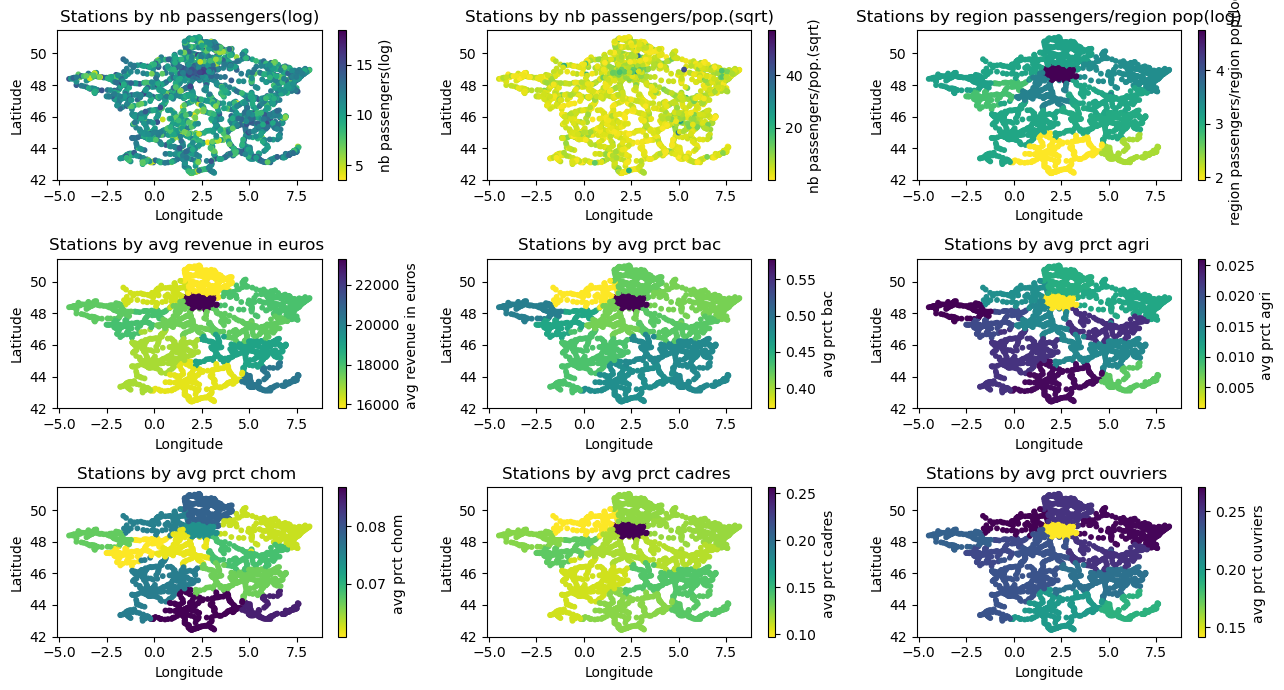

In [30]:
plot_square(lon=df_for_map["lon_gare"],lat=df_for_map["lat_gare"],
    fields_names=[
        [df_for_map["total_voyageurs_2022_log"], "nb passengers(log)"],
        [np.sqrt(df_for_map["ratio_voyag_popul"]),"nb passengers/pop.(sqrt)"],
        [
            np.log(
                df_for_map["total_voyageurs_2022_sum"]
                / df_for_map["pop2022_sum"]
            ),
            "region passengers/region pop(log)",
        ],
        [
            (df_for_map["revmoy2022_mean"]),
            "avg revenue in euros ",
        ],
        [
            df_for_map["pbac2022_mean"],
            "avg prct bac",
        ],
        [
            df_for_map["pagri2022_mean"],
            "avg prct agri ",
        ],
        [
            (df_for_map["pchom2022_mean"]),
            "avg prct chom ",
        ],
        [
            df_for_map["pcadr2022_mean"],
            "avg prct cadres ",
        ],
        [
            df_for_map["pouvr2022_mean"],
            "avg prct ouvriers ",
        ],
       
        
        
       
    ], plot_type="map",
            columns=3,
)